In [97]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from utils import *
from sklearn.metrics import mean_squared_error, r2_score

In [98]:
df_train = pd.read_parquet("data/nyc-taxis-tips/train_preprocessed.parquet")
X = df_train.drop("tip_amount", axis=1)
Y = df_train['tip_amount']
display(X.columns)

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
       'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
       'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
       'DO_location_lon', 'hour', 'is_rush_hour', 'duration', 'PU_loc',
       'DO_loc', 'VendorID_1', 'VendorID_2', 'RatecodeID_1.0',
       'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0',
       'RatecodeID_99.0', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y',
       'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4',
       'PU_borough_7', 'PU_borough_1', 'PU_borough_3', 'PU_borough_4',
       'PU_borough_2', 'PU_borough_6', 'PU_borough_5', 'DO_borough_7',
       'DO_borough_1', 'DO_borough_3', 'DO_borough_4', 'DO_borough_2',
       'DO_borough_6', 'DO_borough_5', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',

# Ridge regression

All this code is from TP_reg-1 (copy paste for clarity in a separate notebook without exploratory data analysis)

In [99]:
# divise les données 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape)

(75000, 55) (25000, 55)


In [100]:
# normaliser les données 

# Séparation des colonnes encodées (one-hot encoded) et des colonnes numériques à normaliser
columns_to_norm = [
    'passenger_count',
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
    'hour', 'duration'
]
cols_to_exclude = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
    'DO_location_lon', 'PU_loc', 'DO_loc',
]
X_train = X_train.drop(cols_to_exclude, axis=1)
X_test = X_test.drop(cols_to_exclude, axis=1)

# Normaliser les colonnes numériques de l'ensemble d'entraînement
scaler = StandardScaler()
X_train_normed = X_train.copy()
X_test_normed = X_test.copy()

# Normalisation sur l'ensemble d'entraînement
X_train_normed[columns_to_norm] = scaler.fit_transform(X_train[columns_to_norm])

# Appliquer la même transformation sur l'ensemble de test
X_test_normed[columns_to_norm] = scaler.transform(X_test[columns_to_norm])

In [101]:
# Modèle Ridge : 
model_ridge_CV = RidgeCV(alphas=np.linspace(15, 25, 100))
model_ridge_CV.fit(X_train_normed, y_train)
y_pred = model_ridge_CV.predict(X_test_normed)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print("Mean Squared Error (MSE):", mse)
print("Coefficient de détermination (R2 Score):", r2)
print("meilleur alpha : ", model_ridge_CV.alpha_)

Mean Squared Error (MSE): 5.32042050920645
Coefficient de détermination (R2 Score): 0.60980263593599
meilleur alpha :  22.676767676767675


In [103]:
# test data for Kaggle submission
test = pd.read_parquet("data/nyc-taxis-tips/test_preprocessed.parquet")

columns_to_norm = [
    'passenger_count',
    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount',
    'improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
    'hour', 'duration'
]
cols_to_exclude = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'PU_location_lat', 'PU_location_lon', 'DO_location_lat',
    'DO_location_lon', 'PU_loc', 'DO_loc', 
    'RatecodeID_6.0', # not in training data
]
X_sub = test.drop(cols_to_exclude, axis=1)

X_sub[columns_to_norm] = scaler.transform(X_sub[columns_to_norm])

predictions = model_ridge_CV.predict(X_sub)

In [107]:
df_pred = pd.DataFrame(predictions, columns=["tip_amount"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))
df_pred.loc[df_pred.tip_amount < 0, "tip_amount"] = 0
df_pred.to_parquet("submission/nyc-taxis-tips/regression_sub_1bis.parquet", index=False)

,row_ID,tip_amount
0,0,8.493263
1,1,3.174099
2,2,3.716245
3,3,4.397425
4,4,3.237968
5,5,5.888253
6,6,3.231023
7,7,-0.840624
8,8,13.365689
9,9,3.960390


In [105]:
df_pred.head(25)

,row_ID,tip_amount
0,0,8.493263
1,1,3.174099
2,2,3.716245
3,3,4.397425
4,4,3.237968
5,5,5.888253
6,6,3.231023
7,7,0.000000
8,8,13.365689
9,9,3.960390


<Axes: xlabel='tip_amount', ylabel='Count'>

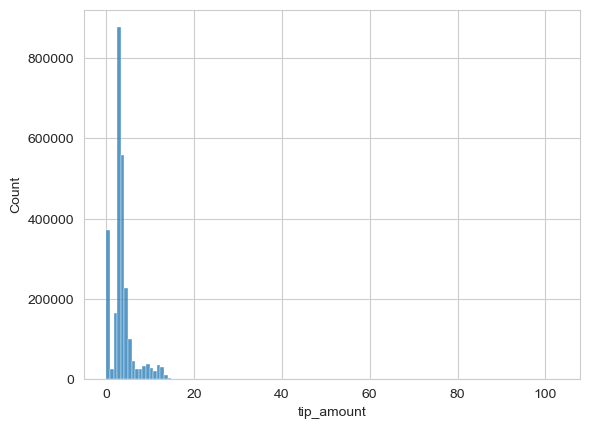

In [106]:
sns.histplot(df_pred, x="tip_amount", bins=125)